# **Conv Autoencoder for Larger data set**

## **1. Call dataset**

In [27]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D, Dense, UpSampling2D, Flatten, Reshape
from tensorflow.keras.datasets.fashion_mnist import load_data
import numpy as np
import matplotlib.pyplot as plt

In [28]:
print("TensorFlow Version:", tf.__version__)
print("GPU is available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.10.0
GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
os.listdir('/home/JGY/mri_cnn/data/larger_Dataset/Training')

['glioma', 'pituitary', 'notumor', 'meningioma']

In [12]:
data_path = '/home/JGY/mri_cnn/data/larger_Dataset/Training'

# Create an empty list to store the data
data = []
# Loop over the directories in the DATA directory
for dir_name in os.listdir(data_path):
    # Loop over the image files in the directory
    for file_name in os.listdir(os.path.join(data_path, dir_name)):
        if file_name.endswith('.jpg'):
            
            img_path = os.path.join(data_path, dir_name, file_name)
            
            class_name = dir_name
 
            data.append((img_path, class_name))  # one sample is tuple : (image_path, class_name) 

df = pd.DataFrame(data, columns=['image_path', 'class_name'])
print(df.shape,'\n', sorted(df['class_name'].unique()),'\n', df['class_name'].nunique())

(5712, 2) 
 ['glioma', 'meningioma', 'notumor', 'pituitary'] 
 4


In [13]:
data_path = '/home/JGY/mri_cnn/data/larger_Dataset/Testing'

# Create an empty list to store the data
data = []
# Loop over the directories in the DATA directory
for dir_name in os.listdir(data_path):
    # Loop over the image files in the directory
    for file_name in os.listdir(os.path.join(data_path, dir_name)):
        if file_name.endswith('.jpg'):
            
            img_path = os.path.join(data_path, dir_name, file_name)
            
            class_name = dir_name
 
            data.append((img_path, class_name))  # one sample is tuple : (image_path, class_name) 

df_test = pd.DataFrame(data, columns=['image_path', 'class_name'])
print(df_test.shape,'\n', sorted(df_test['class_name'].unique()),'\n', df_test['class_name'].nunique())

(1311, 2) 
 ['glioma', 'meningioma', 'notumor', 'pituitary'] 
 4


## **2.preprocessing & visualization**

In [19]:
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image

#train and validation

X = df['image_path']
y_train = df['class_name']

X_train = []
for path in X:
    img = Image.open(path)
    img = img.convert('L')
    img = img.resize((80, 80))
    img = np.array(img)
    X_train.append(img)
X_train = np.array(X_train)

# X_train과 y_train을 80-20 비율로 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print('Train set:', X_train.shape, y_train.shape)
print('Validation set:', X_val.shape, y_val.shape,y_val.unique())

Train set: (4569, 80, 80) (4569,)
Validation set: (1143, 80, 80) (1143,) ['meningioma' 'pituitary' 'notumor' 'glioma']


In [18]:
y_test = df_test['class_name']
X_test = []
for path in df_test['image_path']:
    img = Image.open(path)
    img = img.convert('L')
    img = img.resize((80, 80))  # resize to desired shape
    img = np.array(img)  # convert to numpy array
    X_test.append(img)
X_test = np.array(X_test)  # convert list of images to numpy array
X_test.shape, y_test.shape

((1311, 80, 80), (1311,))

In [22]:
X_trains = X_train / np.max(X_train)
X_tests = X_test / np.max(X_train)
X_vals = X_val/np.max(X_train)
X_tests[0].min(), X_tests[0].max()

(0.0, 0.6862745098039216)

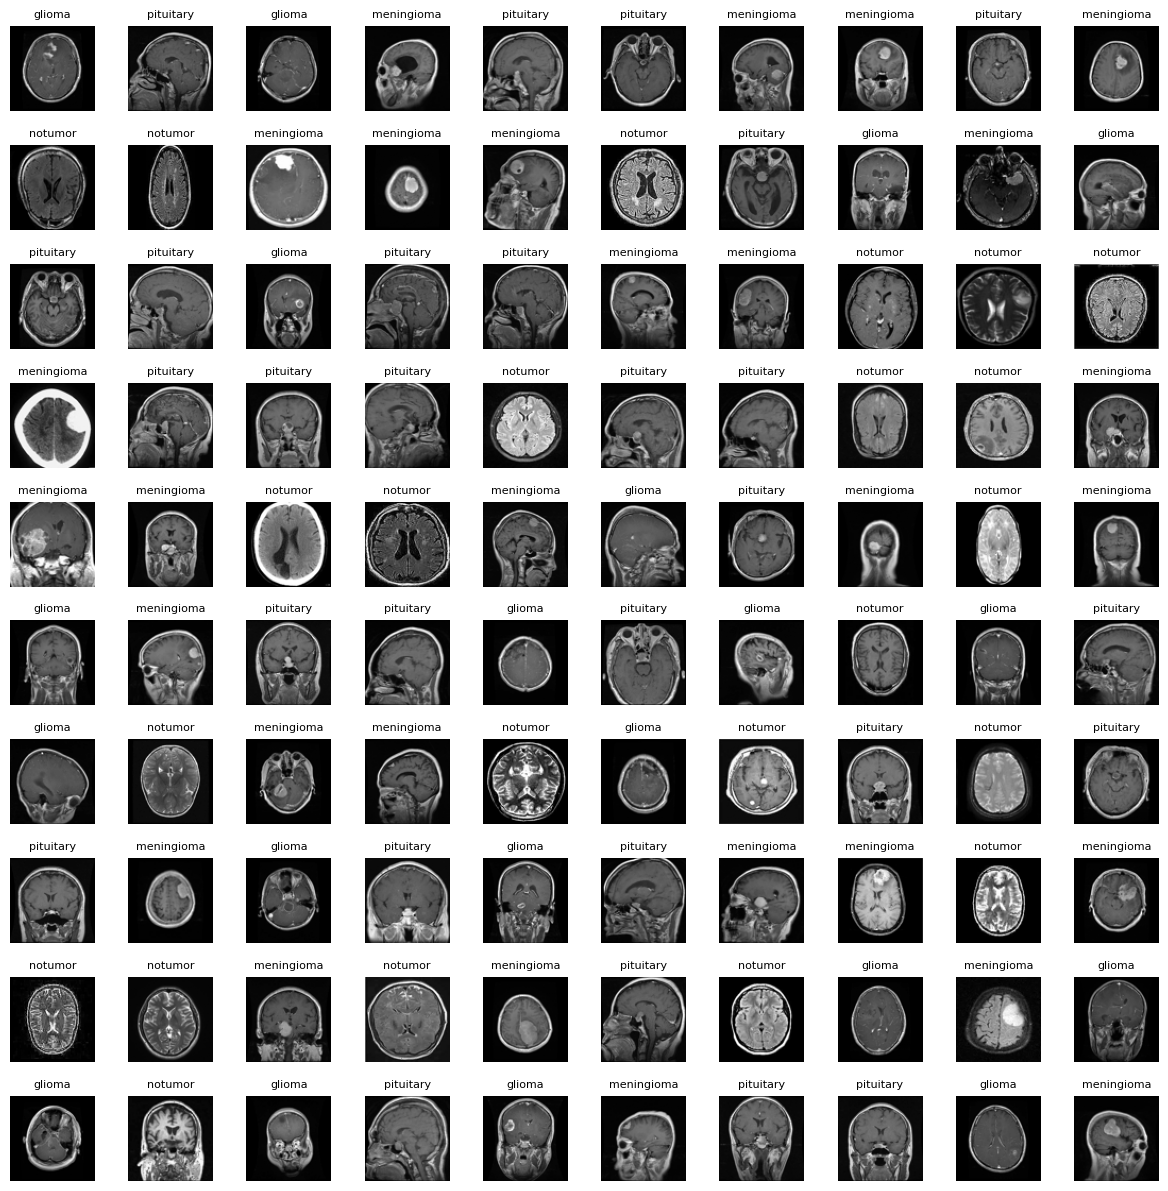

In [29]:
width = 10
height = 10

fig, axes = plt.subplots(height, width, figsize = (15,15))
axes = axes.ravel()
for i in np.arange(0, width * height):
    index = np.random.randint(0, len(X_trains))  
    axes[i].imshow(X_trains[index], cmap = 'gray' )
    axes[i].set_title(y_train.iloc[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

## **3. no argumentation train → test, freeze**

In [ ]:
#train autoencoder

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

# 입력 정의 (예: 80x80x3 이미지)
input_img = Input(shape=(80, 80, 1))

# --- Encoder ---
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)#
x = BatchNormalization()(x)#
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.1)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)#
x = BatchNormalization()(x)#
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.1)(x)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = BatchNormalization()(encoded)
#encoded =  MaxPooling2D((2, 2))(encoded)  #뭔가 이상

# --- Decoder ---
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)#
x = BatchNormalization()(x)#
x = UpSampling2D((2, 2))(x)
x = Dropout(0.1)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)#
x = BatchNormalization()(x)#
x = UpSampling2D((2, 2))(x)
x = Dropout(0.1)(x)
decoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(decoded)  #이상해서 수정

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()
# 비지도 reconstruction 학습
#autoencoder.fit(X_trains, X_trains, epochs=100, batch_size=32)
autoencoder.fit(X_trains, X_trains, epochs=120, batch_size=4, validation_data=(X_vals, X_vals))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 80, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 80, 80, 128)       1280      
                                                                 
 batch_normalization_14 (Bat  (None, 80, 80, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 80, 80, 128)       147584    
                                                                 
 batch_normalization_15 (Bat  (None, 80, 80, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 80, 80, 128)       1475

41/41 [==============================] - 0s 11ms/step


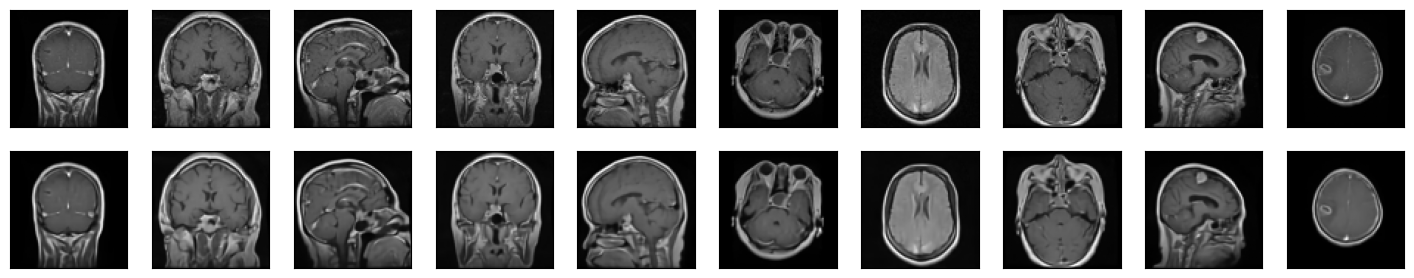

In [71]:
#check performance of autoencoder
decoded_val_images = autoencoder.predict(X_vals)
decoded_test_images = autoencoder.predict(X_tests)

n_images = 10
test_images = np.random.randint(0, X_vals.shape[0], size = n_images)
plt.figure(figsize=(18,18))
for i, image_index in enumerate(test_images):
  # input images
  ax = plt.subplot(10,10, i + 1)
  plt.imshow(X_vals[image_index],cmap='gray')
  plt.xticks(())
  plt.yticks(())

  # Decoded train
  #ax = plt.subplot(10,10, i + 1 + n_images)
  #plt.imshow(coded_test_images[image_index], cmap='gray')
  #plt.xticks(())
  #plt.yticks(())

  # Decoded val
  ax = plt.subplot(10,10, i + 1 + n_images )
  plt.imshow(decoded_val_images[image_index],cmap='gray')
  plt.xticks(())
  plt.yticks(())
  

In [ ]:
#train downstream classifier using encoder output

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np

# 1. str type label to int type label
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y_train)
y_val_int = label_encoder.transform(y_val)
y_test_int = label_encoder.fit_transform(y_test)

# 2. int type label to one-hot label
y_onehot = to_categorical(y_int, num_classes=4)
y_val_onehot = to_categorical(y_val_int, num_classes=4)
y_test_onehot = to_categorical(y_test_int, num_classes=4)


print(y_onehot.shape)
print(y_onehot[0])



# extract encoder part to create a new model
encoder_model = Model(inputs=input_img, outputs=encoded)

# CAM-compatible classifier head
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_model.output)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

# Last convolutional layer with 4 filters (for 4 classes)
last_conv_layer = Conv2D(4, (3, 3), activation='relu', padding='same', name='last_conv')(x)

# Global Average Pooling and Dense layer
x = GlobalAveragePooling2D()(last_conv_layer)
out = Dense(4, activation='softmax', name='output_layer')(x)

# 0. model 정의
classifier = Model(inputs=input_img, outputs=out)
# 1. encoder 가중치 freeze
for layer in encoder_model.layers:
    layer.trainable = False

# 2. compile model
optimizer = Adam(learning_rate=0.001)
classifier.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
classifier.summary()

# 3. Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_classifier_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history = classifier.fit(X_trains, y_onehot, epochs=80, batch_size=64, validation_data=(X_vals,y_val_onehot), callbacks=[early_stopping, model_checkpoint])

print('fitting done')

(4569, 4)
[0. 1. 0. 0.]
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 80, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 80, 80, 128)       1280      
                                                                 
 batch_normalization_14 (Bat  (None, 80, 80, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 80, 80, 128)       147584    
                                                                 
 batch_normalization_15 (Bat  (None, 80, 80, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None

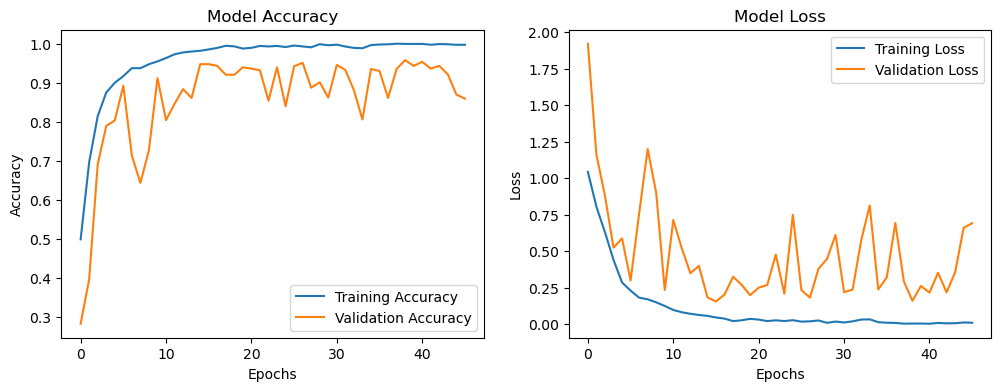

In [67]:

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [44]:
y_test_int

array([0, 0, 0, ..., 1, 1, 1])

In [68]:
# Load the best model
classifier.load_weights('best_classifier_model.h5')

# CAM Visualization
cam_model = Model(inputs=classifier.input, outputs=(classifier.get_layer('last_conv').output, classifier.output))


#y_test_int = label_encoder.fit_transform(y_test)

# predict
y_pred_prob = classifier.predict(X_tests)  # 클래스별 확률 출력 (num_samples, 4)
y_pred = y_pred_prob.argmax(axis=1)       # 가장 높은 확률 클래스로 변환 (정수 인코딩)


# eval
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

acc = accuracy_score(y_test_int, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# classification report
print(classification_report(y_test_int, y_pred, target_names=label_encoder.classes_))

# confusion matrix(선택사항)
cm = confusion_matrix(y_test_int, y_pred)
print("Confusion Matrix:")
print(cm)

41/41 [==============================] - 0s 7ms/step
Test Accuracy: 0.9550
              precision    recall  f1-score   support

      glioma       0.95      0.91      0.93       300
  meningioma       0.90      0.92      0.91       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311

Confusion Matrix:
[[273  26   0   1]
 [ 13 282   5   6]
 [  0   1 404   0]
 [  1   6   0 293]]


In [61]:
import random
random.sample(range(1000), 10)

[464, 892, 396, 913, 70, 609, 274, 540, 986, 693]

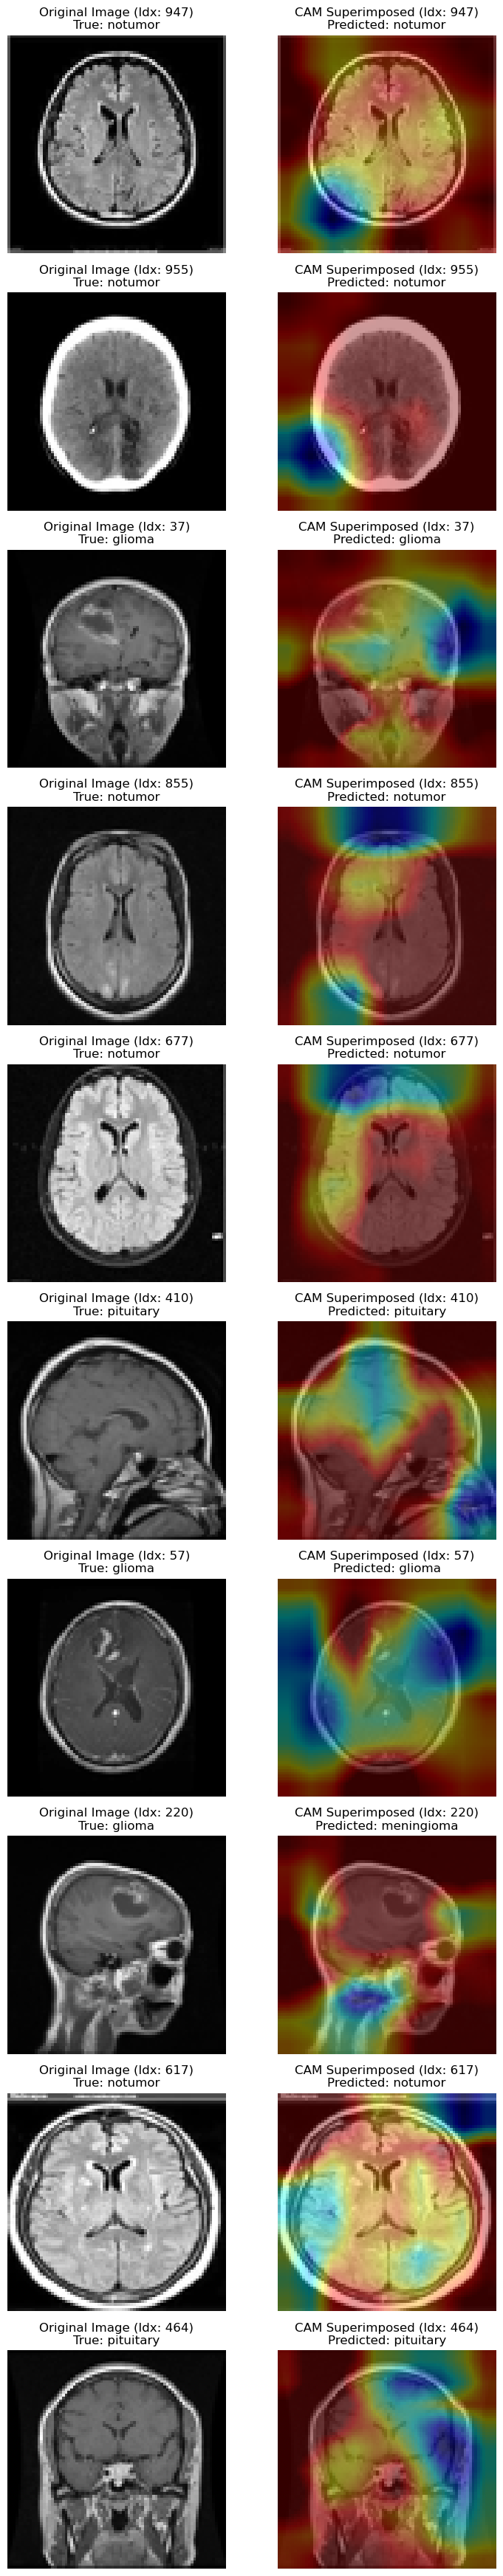

In [70]:
import random
import numpy as np
import cv2
# (Keras/TensorFlow의 Model, matplotlib.pyplot as plt, label_encoder, X_tests, y_test_onehot 등은 이미 로드되었다고 가정)


# Load the best model
classifier.load_weights('best_classifier_model.h5')

# CAM Visualization
cam_model = Model(inputs=classifier.input, outputs=(classifier.get_layer('last_conv').output, classifier.output))

# ==============================================================================
# 💡 수정된 get_cam 함수: 레이블을 계산하고 반환하도록 수정
# ==============================================================================
def get_cam(image_index):
    # Get the features and prediction from the CAM model
    # verbose=0 추가하여 출력 메시지 최소화
    features, results = cam_model.predict(X_tests[image_index:image_index+1], verbose=0) 
    
    # Get the weights of the dense layer (최종 출력 레이어 이름이 'output_layer'라고 가정)
    dense_weights = classifier.get_layer('output_layer').get_weights()[0]
    
    # Get the predicted class index
    predicted_class_index = np.argmax(results[0])
    
    # Get the weights for the predicted class
    class_weights = dense_weights[:, predicted_class_index]
    
    # Create the CAM
    cam = np.dot(features[0], class_weights)
    
    # Resize CAM to original image size (80x80)
    cam = cv2.resize(cam, (80, 80))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)
    
    # Original image
    original_image = X_tests[image_index]
    
    # Superimpose heatmap on original image
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    
    # 원본 이미지 타입 변환 (float64 -> uint8)
    original_image_uint8 = (original_image * 255).astype('uint8')
    
    superimposed_img = cv2.addWeighted(
        cv2.cvtColor(original_image_uint8, cv2.COLOR_GRAY2BGR), 0.6, heatmap, 0.4, 0)
        
    # **레이블 계산:** 함수가 레이블을 반환해야 하므로 여기서 계산
    predicted_label = label_encoder.inverse_transform([predicted_class_index])[0]
    true_label = label_encoder.inverse_transform([np.argmax(y_test_onehot[image_index])])[0]
    
    # 모든 필요한 결과값을 반환
    return superimposed_img, original_image, predicted_label, true_label

# ==============================================================================
# 💡 수정된 시각화 코드: 무작위 샘플 추출 및 인덱스 오류 해결
# ==============================================================================

# X_tests의 길이 내에서 중복 없는 무작위 인덱스 10개 추출
try:
    test_size = len(X_tests)
    # X_tests의 크기가 10개 미만일 경우를 대비하여 min() 사용
    random_indices = random.sample(range(test_size), min(10, test_size)) 
except NameError:
    print("경고: X_tests가 정의되지 않았습니다. 인덱스 범위를 확인하세요.")
    exit()

num_samples = len(random_indices)

# Display N examples (Original vs. CAM)
# 행 크기를 추출된 샘플 수에 맞게 동적으로 설정합니다.
fig, axes = plt.subplots(num_samples, 2, figsize=(8, 3.5 * num_samples)) 

# enumerate를 사용하여 i (플롯 행 인덱스: 0~9)와 image_index (데이터 인덱스: 무작위 값)를 분리
for i, image_index in enumerate(random_indices): 
    
    # 1. get_cam 함수 호출
    # get_cam 함수가 이제 레이블을 반환합니다.
    superimposed_img, original_img, predicted_label, true_label = get_cam(image_index)
    
    # ----------------------------------------
    # Column 1: Original Image
    # ----------------------------------------
    ax_orig = axes[i, 0] # i를 플롯 행 인덱스로 사용 (0부터 시작)
    # 이미지 차원이 (80, 80, 1)일 경우를 대비하여 squeeze() 사용
    ax_orig.imshow(original_img.squeeze(), cmap='gray') 
    ax_orig.set_title(f'Original Image (Idx: {image_index})\nTrue: {true_label}', fontsize=12)
    ax_orig.axis('off')
    
    # ----------------------------------------
    # Column 2: CAM Image
    # ----------------------------------------
    ax_cam = axes[i, 1] # i를 플롯 행 인덱스로 사용 (0부터 시작)
    ax_cam.imshow(superimposed_img)
    ax_cam.set_title(f'CAM Superimposed (Idx: {image_index})\nPredicted: {predicted_label}', fontsize=12)
    ax_cam.axis('off')

plt.tight_layout() # 간격 최적화
plt.show() # 결과 출력